# Facial recognition via CNN

State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. Let's first use Keras to build a CNN and train it with the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset, and follow that by building a similar model that employs transfer learning.

![](Images/cnn.png)

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

Unlike in previous examples in which we loaded 62x47 grayscale images, this time we will load full-resolution color images. We need larger RGB images in order to experiment with transfer learning later on.

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, color=True)
image_count = faces.images.shape[0]
image_width = faces.images.shape[1]
image_height = faces.images.shape[2]
image_channels = faces.images.shape[3]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 125, 94, 3)


In total, 1,140 facial images were loaded. Each image measures 125 by 94 pixels. Let's check the balance in the dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes, that our neural network will try to predict.

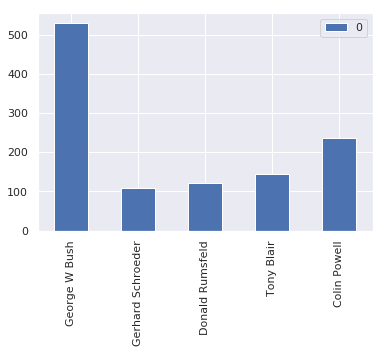

In [2]:
%matplotlib inline
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

Let's plot some of the facial images so we can see what they look like.

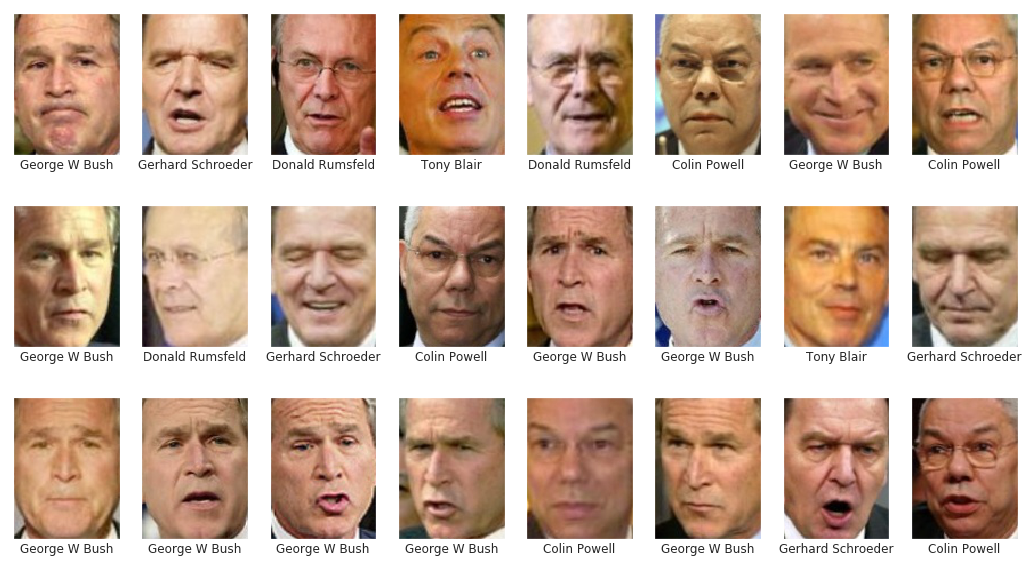

In [3]:
fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255) # Reduce pixel values to 0.0 to 1.0 so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

The next step is to convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. After that, we'll split the data for training and testing. Rather than allow Keras to do the splitting, we'll use Scikit-learn's `train_test_split` function.

In [4]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = faces.images / 255 # Scale pixel values from 0-255 to 0-1
face_labels = to_categorical(faces.target)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, random_state=42)

Using TensorFlow backend.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Build and train a convolutional neural network

Let's build a CNN that contains two pairs of convolution and pooling layers followed by a classification layer containing 128 neurons and a `softmax` layer that outputs probabilities for each class.

In [5]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, image_channels)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 92, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40832)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5226624   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

Now call `fit` to train the model.

In [6]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/20
912/912 [==============================] - 55s 60ms/step - loss: 1.6205 - accuracy: 0.4112 - val_loss: 1.3575 - val_accuracy: 0.4649
Epoch 2/20
912/912 [==============================] - 51s 56ms/step - loss: 1.3175 - accuracy: 0.4945 - val_loss: 1.2420 - val_accuracy: 0.5833
Epoch 3/20
912/912 [==============================] - 53s 58ms/step - loss: 1.0483 - accuracy: 0.5811 - val_loss: 0.8146 - val_accuracy: 0.7281
Epoch 4/20
912/912 [==============================] - 52s 57ms/step - loss: 0.6620 - accuracy: 0.7752 - val_loss: 0.6230 - val_accuracy: 0.7719
Epoch 5/20
912/912 [==============================] - 52s 57ms/step - loss: 0.4474 - accuracy: 0.8399 - val_loss: 0.4747 - val_accuracy: 0.8465
Epoch 6/20
912/912 [==============================] - 50s 55ms/step - loss: 0.2353 - accuracy: 0.9265 - val_loss: 0.3915 - val_accuracy: 0.8465
Epoch 7/20
912/912 [==============================] - 50s 55ms/step - loss: 0.1133 - accur

With training complete, plot the training and validation accuracy to see how well the network performed.

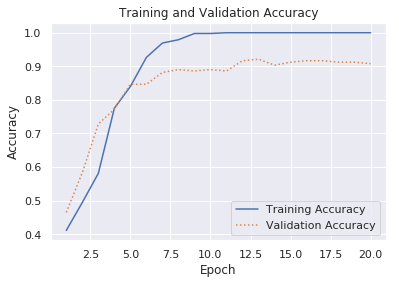

In [7]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(hist)

Run some test data through the network and use a confusion matrix to see how it fared.

Text(89.18, 0.5, 'Predicted label')

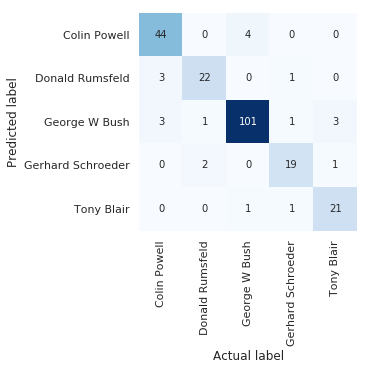

In [8]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

In all likelihood, the CNN exhibited slightly better accuracy than a traditional neural network. Given a sufficient number of training images, state-of-the-art CNNs can sometimes execeed a human's ability to classify images.

## Use transfer learning to classify faces

Could we improve the accuracy of our facial-recognition model by using a pretrained CNN rather than building our own — that is, by employing transfer learning? There's one way to find out. Let's use [VGG-16](https://neurohive.io/en/popular-networks/vgg16/) as our base and use it to do feature extraction, and then train our own classification layer with the output.

In [9]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, image_channels))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 94, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 94, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 94, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 47, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 47, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 47, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 23, 128)       0     

Next, preprocess the training and testing images and run them through VGG-16.

In [10]:
from keras.applications.vgg16 import preprocess_input

# Rebase the facial images for VGG-16
face_images = faces.images # Do NOT divide by 255 this time
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, random_state=42)

# Preprocess the images for input to VGG-16
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Run the preprocessed images through the base model to extract features
x_train = base_model.predict(x_train)
x_test = base_model.predict(x_test)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Build a network for classification and train it with the output from VGG-16.

In [11]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Train on 912 samples, validate on 228 samples
Epoch 1/20
912/912 [==============================] - 2s 2ms/step - loss: 2.0638 - accuracy: 0.6020 - val_loss: 0.5541 - val_accuracy: 0.8202
Epoch 2/20
912/912 [==============================] - 1s 1ms/step - loss: 0.2702 - accuracy: 0.9090 - val_loss: 0.3571 - val_accuracy: 0.8728
Epoch 3/20
912/912 [==============================] - 1s 1ms/step - loss: 0.1081 - accuracy: 0.9605 - val_loss: 0.3753 - val_accuracy: 0.8640
Epoch 4/20
912/912 [==============================] - 1s 1ms/step - loss: 0.0433 - accuracy: 0.9945 - val_loss: 0.3565 - val_accuracy: 0.8816
Epoch 5/20
912/912 [==============================] - 1s 1ms/step - loss: 0.0228 - accuracy: 0.9978 - val_loss: 0.2969 - val_accuracy: 0.9123
Epoch 6/20
912/912 [==============================] - 1s 1ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.9123
Epoch 7/20
912/912 [==============================] - 1s 1ms/step - loss: 0.0101 - accuracy: 1.0000 - 

With training complete, plot the training and validation accuracy to see how well the network performed.

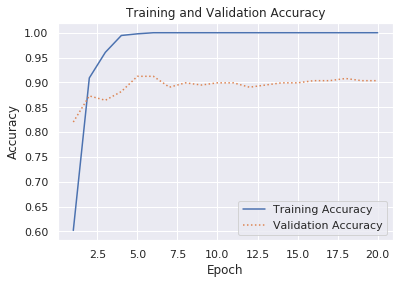

In [12]:
show_history(hist)

Once more, let's use a confusion matrix to see how accurately the network works with the test images in `x_test` and the labels in `y_test`.

Text(89.18, 0.5, 'Predicted label')

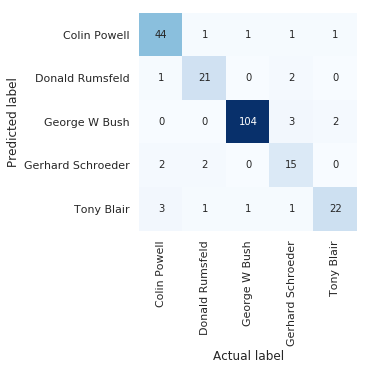

In [13]:
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

How does the accuracy of this model compare to that of the previous one? (Note that it won't necessarily be more accurate.) How do the training times compare?